In [1]:
from __future__ import print_function, division

In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


In [5]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [6]:
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

In [7]:
def remove_nan_examples(data):
    newX = []
    for i in range(len(data)):
        if np.isnan(data[i]).any() == False:
            newX.append(data[i])
    return newX

In [8]:
import matplotlib.pylab as plt
import pandas as pd

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *

from keras import backend as K
import seaborn as sns
sns.despine()

In [10]:
def data2change(data):
    change = pd.DataFrame(data).pct_change()
    change = change.replace([np.inf, -np.inf], np.nan)
    change = change.fillna(0.).values.tolist()
    change = [c[0] for c in change]
    return change

In [11]:
WINDOW = 5
EMB_SIZE = 6
STEP = 1
FORECAST = 1

In [14]:
data_original = pd.read_csv('dataset/700_data_from_IB_1day.csv')[::-1]

In [15]:
openp = data_original.loc[:, 'open'].tolist()
highp = data_original.loc[:, 'high'].tolist()
lowp = data_original.loc[:, 'low'].tolist()
closep = data_original.loc[:, 'close'].tolist()
volumep = data_original.loc[:, 'volume'].tolist()

In [16]:
openp = data2change(openp)
highp = data2change(highp)
lowp = data2change(lowp)
closep = data2change(closep)
volumep = data2change(volumep)

In [17]:
volatility = []
for i in range(WINDOW, len(openp)):
    window = highp[i-WINDOW:i]
    volatility.append(np.std(window))

In [18]:
openp, highp, lowp, closep, volumep = openp[WINDOW:], highp[WINDOW:], lowp[WINDOW:], closep[WINDOW:], volumep[WINDOW:]

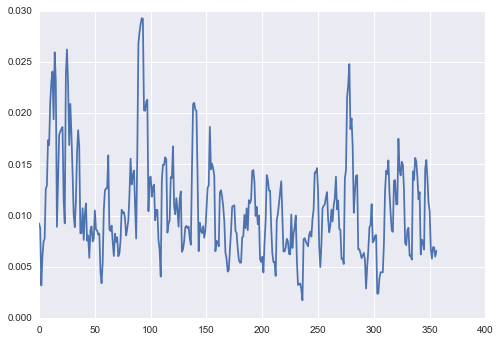

In [19]:
plt.plot(volatility)
plt.show()

In [20]:
X, Y = [], []
for i in range(0, len(data_original), STEP): 
    try:
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]

        volat = volatility[i:i+WINDOW]

        y_i = volatility[i+WINDOW+FORECAST] 
#        y_i = closep[i+WINDOW+FORECAST] 
        x_i = np.column_stack((volat, o, h, l, c, v))

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

In [33]:
class GAN():
    
    def shuffle_in_unison(a, b):
        # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
        assert len(a) == len(b)
        shuffled_a = np.empty(a.shape, dtype=a.dtype)
        shuffled_b = np.empty(b.shape, dtype=b.dtype)
        permutation = np.random.permutation(len(a))
        for old_index, new_index in enumerate(permutation):
            shuffled_a[new_index] = a[old_index]
            shuffled_b[new_index] = b[old_index]
        return shuffled_a, shuffled_b
    
    def create_Xt_Yt(X, y, percentage=0.9):
        p = int(len(X) * percentage)
        X_train = X[0:p]
        Y_train = y[0:p]

        X_train, Y_train = shuffle_in_unison(X_train, Y_train)

        X_test = X[p:]
        Y_test = y[p:]

        return X_train, X_test, Y_train, Y_test
    
    def remove_nan_examples(data):
        newX = []
        for i in range(len(data)):
            if np.isnan(data[i]).any() == False:
                newX.append(data[i])
        return newX
    
    def data2change(data):
        change = pd.DataFrame(data).pct_change()
        change = change.replace([np.inf, -np.inf], np.nan)
        change = change.fillna(0.).values.tolist()
        change = [c[0] for c in change]
        return change
    
    def dataReader(self):
        
        data_original = pd.read_csv('dataset/700_data_from_IB_1day.csv')[::-1]
        
        openp = data_original.loc[:, 'open'].tolist()
        highp = data_original.loc[:, 'high'].tolist()
        lowp = data_original.loc[:, 'low'].tolist()
        closep = data_original.loc[:, 'close'].tolist()
        volumep = data_original.loc[:, 'volume'].tolist()
        
        openp = data2change(openp)
        highp = data2change(highp)
        lowp = data2change(lowp)
        closep = data2change(closep)
        volumep = data2change(volumep)
        
        volatility = []
        for i in range(WINDOW, len(openp)):
            window = highp[i-WINDOW:i]
            volatility.append(np.std(window))
            
        openp, highp, lowp, closep, volumep = openp[WINDOW:], highp[WINDOW:], lowp[WINDOW:], closep[WINDOW:], volumep[WINDOW:]
        
        X, Y = [], []
        for i in range(0, len(data_original), STEP): 
            try:
                o = openp[i:i+WINDOW]
                h = highp[i:i+WINDOW]
                l = lowp[i:i+WINDOW]
                c = closep[i:i+WINDOW]
                v = volumep[i:i+WINDOW]

                volat = volatility[i:i+WINDOW]

                y_i = volatility[i+WINDOW+FORECAST] 
        #        y_i = closep[i+WINDOW+FORECAST] 
                x_i = np.column_stack((volat, o, h, l, c, v))

            except Exception as e:
                break

            X.append(x_i)
            Y.append(y_i)

        X, Y = np.array(X), np.array(Y)
        X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)
        
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))
        
        return X_train, X_test, Y_train, Y_test 
        
    
    
    def __init__(self):
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        self.WINDOW = 5
        self.EMB_SIZE = 6
        self.STEP = 1
        self.FORECAST = 1
        

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        X_train, X_test, Y_train, Y_test = self.dataReader()

        # Rescale -1 to 1
#        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#        X_train = np.expand_dims(X_train, axis=3)
        
        #Get the Data here....
        
        
        
        
        
        
        

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("gan/images/mnist_%d.png" % epoch)
        plt.close()

In [34]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, save_interval=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

ValueError: Error when checking input: expected input_19 to have 4 dimensions, but got array with shape (16, 5, 6)